<a href="https://colab.research.google.com/github/jjyjung/ai/blob/gh-pages/%ED%9A%8C%EC%A0%84%EA%B8%B0%EA%B3%84_%EA%B3%A0%EC%9E%A5%EC%A7%84%EB%8B%A8_%EC%8B%A4%EC%8A%B5_ML_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **회전기계 고장진단 실습**

회전기계에서 수집된 진동센서 데이터를 전처리하고, 머신러닝 기법을 이용하여 회전기계의 고장 여부를 판단함

본 자료는 정부에서 운영하는 아래의 KAMP(한국인공지능제조플랫폼)의 데이터와 설명자료를 활용하였고, 교육을 위한 머신러닝 코드를 새롭게 추가하였습니다.

 https://www.kamp-ai.kr/front/dataset/AiDataDetail.jsp?AI_SEARCH=&page=1&DATASET_SEQ=18

## 0. 회전기계 및 실험 환경

* 산업 현장에서 사용되는 기계 구조물은 대부분 정상 상태로 가동되며, 수집되는 데이터 역시 정상 유형이 90% 이상을 차지하고 고장 데이터는 충분하지 않다.
* Rotor testbed를 이용하여, 여러 고장유형에 대해 특징을 분석하고 정상 및 고장유형을 분류할 수 있는 충분한 양의 고장 데이터를 수집할 수 있다. 
* 많은 산업 현장(발전소 등)에서 주로 사용되는 회전 설비의 진동데이터를 수집하고 고장을 분석 및 진단하는 학습 모델을 구축하여, 이후 기술 확장을 통해 발전소나 대규모 공장의 자동화 라인 등에 활용하는 것을 목표로 한다.

![fig.01.png](https://github.com/jjyjung/ai_mfg/blob/main/img/fig.01.png?raw=true&style=centerme)<br>

(1) Controller Module
- 본 rotor testbed의 Controller에서 수동 모드를 이용하여 Motor 회전속도가 약 1500 RPM인 경우, 진동 데이터를 구축하였다. <br>
<br>

(2) BLDC Motor
- 본 rotor testbed는 BLDC (Brushless DC) Motor는 Brush가 없어서 기계적인 접촉이 없는 DC Motor이다.
- BLDC Motor는 소음이 비교적 적으며, 출력을 세밀하게 조절할 수 있다는 장점이 있다.<br>
![BLDC_motor.jpg](https://raw.githubusercontent.com/jjyjung/ai_mfg/main/img/BLDC_motor.jpg)<br>
<br>

(3) Disk
- 본 rotor testbed는 총 2개의 aluminum disk가 있다.
- 각각의 disk에는 회전 불균형을 구현할 수 있는 bolt 체결 홀이 있다.
- 축의 중심으로부터 bolt 체결 홀의 거리는 약 60mm이며, blot 체결 홀은 모두 36개이다.<br>
![fig.02.png](https://github.com/jjyjung/ai_mfg/blob/main/img/fig.02.png?raw=true)<br>
<br>

(4) Rotor Spec.
- 본 rotor testbed의 사양은 다음과 같다.

|    구분    |                 사양                 |
|:----------:|:------------------------------------:|
| Size       | 673 mm (W) x 280 mm (D) x 281 mm (H) |
| Weight     |                 25kg                 |
| Material   |               Aluminum               |
| Bearing    |             6202ZZ x 2EA             |
| Motor      |  DC 12V x 0.25HP (0.2W), 0-3000 RPM  |
| Main power |                AC 220V               |

(5) 실험 환경
- 회전 속도는 약 1500 RPM (Revolutions Per Minute)을 사용하였으며, 이 경우 기계의 최대 주파수는 25 Hz (= 1500 RPM / 60 sec)가 된다.
- 나이퀴스트 (Nyquist) 이론에 따르면 기계의 최대 주파수의 2배 이상으로 sampling rate을 해야하지만, 실제 산업에서는 안정적인 신호 분석을 위해서 통상 최대 주파수의 5-10배 정도의 sampling rate를 수행한다. 
- 본 실험 데이터는 이보다 충분하게 최대 주파수의 40배 정도인 1 kHz의 진동 데이터(가속도)가 수집되어있다.

| Rotor testbed |                   |
|:-------------:|:-----------------:|
| RPM           |     about 1500    |
| Sampling rate | 1 kHz (0.001 sec) |

## 1. 고장실험 데이터
### 1-1. 고장 데이터 수집

- 총 4개의 센서를 사용하므로 sensor1~sensor4로 명명하였다.  <br>
- 센서 데이터 취득 위치는 다음과 같다.<br>
<br>

<center><img src = "https://github.com/jjyjung/ai_mfg/blob/main/img/sensor1.png?raw=true"><br>[센서 설치 위치 (사진)]</center> <br>

<center><img src = "https://github.com/jjyjung/ai_mfg/blob/main/img/sensor2.png?raw=true"><br>[센서 부착 위치 (빨간색)]</center> <br>

<!--center><img src = "https://github.com/jjyjung/ai_mfg/blob/main/img/sensor3.png?raw=true"><br>[group 2]</center> <br>
<br-->

- data는 데이터 취득 시간, 정상 유형(normal)과 고장유형 1-3 (type1, type2, type3)일 경우 센서 취득값으로 구성된다.  <br>
- 고장유형 1,2,3은 다음의 사진과 표를 확인하면 알 수 있다.<br>

![fault_type.png](https://github.com/jjyjung/ai_mfg/blob/main/img/fault_type.png?raw=true)<br>

| 구분   | 특징                                                |
|--------|-----------------------------------------------------|
| Type 1 | Disk 2에 회전 불균형 (270도 위치에 볼트, 너트 부착) |
| Type 2 | Support 4에 지지 불균형                             |
| Type 3 | Type 1 + Type 2                                     |


### 1-2. 고장 데이터 업로드

In [ ]:
# 필요한 패키지(라이브러리) 로딩
import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

 * **[중요] Sensor 파일 4개 업로드**
  * <a href=http://ibiz.khu.ac.kr/jyjung/ target=new>http://ibiz.khu.ac.kr/jyjung/</a> 사이트에 방문하여 **<a href=http://ibiz.khu.ac.kr/jyjung/kia/rotor.zip>rotor.zip</a>** 파일을 다운로드 받으시오. 
  * zip 파일을 풀면 4개의 csv 파일을 생깁니다. 
  * 4개의 csv 파일들을 Colab 왼쪽에 있는 폴더에 업로드 하세요. (drag & drop 하면 됩니다.)

In [ ]:
# 4개 센서 데이터를 읽어들이기 위하여 아래 코드를 실행합니다.
sensor1 = pd.read_csv('/content/g1_sensor1.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])
sensor2 = pd.read_csv('/content/g1_sensor2.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])
sensor3 = pd.read_csv('/content/g1_sensor3.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])
sensor4 = pd.read_csv('/content/g1_sensor4.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])

### 1-3. 데이터 확인
* 불러온 데이터프레임의 변수 이름(예. sensor1, sensor2 등)을 입력하면 해당 내용을 확인해 볼 수 있다.
* **[TEST] 아래 코드에서 sensor 번호를 바꾸어가면서, sensor 2, sensor 3, sensor 4의 내용도 확인해보시오.**

In [ ]:
sensor1

In [ ]:
sensor1['normal']

In [ ]:
print('sensor 1의 데이터 크기', sensor1.shape)
print('sensor 2의 데이터 크기', sensor2.shape)
print('sensor 3의 데이터 크기', sensor3.shape)
print('sensor 4의 데이터 크기', sensor4.shape)

* 140초 간의 데이터가 총 5개의 컬럼으로 이루어져 있다.
* 그러나 데이터 크기를 확인해보면 센서마다 데이터를 취득하는 sampling rate이 다르기 때문에, 데이터 크기가 조금씩 다른 것을 확인할 수 있다.
* 따라서 동일한 time interval의 데이터를 취득하기 위해 데이터를 0.001 sec 간격으로 선형보간한다.

### 1-4. 데이터 선형보간

* 각 센서별 sampling rate은 다음과 같다. <br>

| Sensor 1 | Sensor 2 | Sensor 3 | Sensor 4 |
|:--------:|:--------:|----------|----------|
| 0.000736 | 0.000760 | 0.000714 | 0.000761 |

* 계측된 센서 데이터의 계측 시간 간격 (sampling rate)이 일정하지 않은 경우, 데이터 간 정확한 비교가 어려우므로 계측 시간의 동일화를 위해 전처리(선형 보간)가 요구된다. 선형보간의 방법은 아래 그림과 같다.<br>

![interpolation.png](https://github.com/jjyjung/ai_mfg/blob/main/img/interpolation.png?raw=true)<br>
<br>
* 따라서 표에 나온 sampling rate을 이용하여 각 센서의 데이터를 0.001 sec 간격으로 선형보간 한다 (총 140초). <br>
 - interpolate.interp1d() : [선형보간 함수](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)를 이용하였다.

In [ ]:
from scipy import interpolate

x_new = np.arange(0, 140, 0.001)

y_new1 = []; y_new2 = []; y_new3 = []; y_new4 = []
for item in ['normal', 'type1', 'type2', 'type3']:
    f_linear1 = interpolate.interp1d(sensor1['time'], sensor1[item], kind='linear'); y_new1.append(f_linear1(x_new))
    f_linear2 = interpolate.interp1d(sensor2['time'], sensor2[item], kind='linear'); y_new2.append(f_linear2(x_new))
    f_linear3 = interpolate.interp1d(sensor3['time'], sensor3[item], kind='linear'); y_new3.append(f_linear3(x_new))
    f_linear4 = interpolate.interp1d(sensor4['time'], sensor4[item], kind='linear'); y_new4.append(f_linear4(x_new))
    
sensor1 = pd.DataFrame(np.array(y_new1).T, columns = ['normal', 'type1', 'type2', 'type3'])
sensor2 = pd.DataFrame(np.array(y_new2).T, columns = ['normal', 'type1', 'type2', 'type3'])
sensor3 = pd.DataFrame(np.array(y_new3).T, columns = ['normal', 'type1', 'type2', 'type3'])
sensor4 = pd.DataFrame(np.array(y_new4).T, columns = ['normal', 'type1', 'type2', 'type3'])

* 선형 보간 작업을 위해 데이터를 센서별로 묶어두었지만, 실제 취득된 형태로 데이터를 다시 조정한다.

In [ ]:
normal_ = pd.concat([sensor1['normal'],sensor2['normal'],sensor3['normal'],sensor4['normal']],axis=1)
type1_  = pd.concat([sensor1['type1'], sensor2['type1'], sensor3['type1'], sensor4['type1']], axis=1)
type2_  = pd.concat([sensor1['type2'], sensor2['type2'], sensor3['type2'], sensor4['type2']], axis=1)
type3_  = pd.concat([sensor1['type3'], sensor2['type3'], sensor3['type3'], sensor4['type3']], axis=1)

normal_.columns = ['s1', 's2', 's3', 's4']; type1_.columns = ['s1', 's2', 's3', 's4']
type2_.columns  = ['s1', 's2', 's3', 's4']; type3_.columns = ['s1', 's2', 's3', 's4']

print('normal 상태 데이터의 사이즈', normal_.shape)
print('type1  상태 데이터의 사이즈', type1_.shape)
print('type2  상태 데이터의 사이즈', type2_.shape)
print('type3  상태 데이터의 사이즈', type3_.shape)

* **[TEST] 아래 코드에서 Class 이름을 바꾸어가면서, normal_, type1_, type2_, type3_의 내용도 확인해보시오.**

In [ ]:
normal_

### 1-5. 데이터 분석
* 특정 시간에서의 시계열 샘플을 그래프로 그려봅시다.
* 아래는 Sensor 1의 네 가지 class 중에서 normal와 type1의 그래프를 보여주고 있다.
* **[TEST] Sensor 1의 type3와 type4의 그래프도 그려보시오.** (# 표시를 조정하면 됨)
* **[TEST] Sensor 2의 type3와 type4의 그래프도 그려보시오.** ('s1'을 's2'로 바꾸면 됨)

In [ ]:
# python 버전 : 3.7.3 (버전에 따라, jupyter notebook에서 아래 코드가 실행되지 않을 수 있습니다)
# 실행이 되지 않는 경우, 아래 코드는 주석처리하고 넘어가도 학습에 영향을 주지 않습니다 (데이터 확인용)

plt.figure(figsize = (10, 4))

plt.scatter(range(0,300), normal_['s1'][:300], label="class = normal", marker='o', s=5)
plt.scatter(range(0,300), type1_['s1'][:300], label="class = type1", marker='o', s=5)
# plt.scatter(range(0,300), type2_['s1'][:300], label="class = type2", marker='o', s=5)
# plt.scatter(range(0,300), type3_['s1'][:300], label="class = type3", marker='o', s=5)
    
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=15)
plt.ylabel("Sensor Value", fontsize=15)
plt.show()
plt.close()

### 1.6. 데이터 상관분석
* df.corr()을 입력하면 센서 별 상관관계를 확인할 수 있다.

In [ ]:
normal_.corr()

* Correlation Matrix(상관 행렬)를 통해 센서값 별 상관관계를 이미지로 확인할 수 있다.

In [ ]:
# python 버전 : 3.7.3 (버전에 따라, jupyter notebook에서 아래 코드가 실행되지 않을 수 있습니다)
# 실행이 되지 않는 경우, 아래 코드는 주석처리하고 넘어가도 학습에 영향을 주지 않습니다 (데이터 확인용)

names = ['s1','s2','s3','s4']
cm = np.corrcoef(normal_[names].values.T)
sns.set(font_scale=0.8)
sns.heatmap(cm, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=names, xticklabels=names, cmap=plt.cm.Blues)

절대값이 0.6보다 클수록 강한 상관관계를 가지며, 0.3보다 작을수록 약한 상관관계를 갖는다. <br>
양수의 경우 정(+)의 상관관계, 음수의 경우 부(-)의 상관관계를 갖는다.

## 2. 데이터 전처리

### 2-1. 데이터 필터링 (Filtering)

센서로부터 취득한 데이터는 기본적으로 기계학습에 좋지 않은 영향을 주는 노이즈(Noise)가 포함되어 있다. 센서 데이터에 평균을 취하면 데이터의 노이즈를 제거할 수 있는데, 측정하려는 물리량이 시간에따라 변하는 경우에는 적절하지 않다(데이터의 동적인 변화를 모두 smoothing하는 결과). 따라서 데이터에서 노이즈를 제거하면서, 동적인 변화를 반영하는 방법으로 이동평균필터가 있으며, 본 가이드북에서는 데이터의 노이즈를 처리하기 위해 이동평균필터(Moving Average filter)를 사용하였다. 

- 이동평균필터 (Moving Average filter)는 python에서 [np.convolve()](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) 함수로 구현된다 (MATLAB의 filter 함수와 동일). <br>
    - np.convolve() : 1차원 신호를 입력으로 받아, 최근 M개의 측정값들의 평균을 구한다.
    
    - 모든 데이터의 평균이 아니라, 정해진 크기(M개)의 최근 측정값들로만 평균을 구한다. <br>
    - 일반적으로 신호 데이터의 변동이 빠른 경우에는 M값을 작게하고, 신호 데이터의 변동이 느린 경우에는 M값을 크게한다. <br>
    - 자세한 이론은 [자료](https://www.analog.com/media/en/technical-documentation/dsp-book/dsp_book_Ch15.pdf)를 참고하면 좋다.

In [ ]:
M = 15

normal_s1 = np.convolve(normal_['s1'], np.ones(M), 'valid') / M; normal_s1 = normal_s1.reshape(len(normal_s1),1)
normal_s2 = np.convolve(normal_['s2'], np.ones(M), 'valid') / M; normal_s2 = normal_s2.reshape(len(normal_s2),1)
normal_s3 = np.convolve(normal_['s3'], np.ones(M), 'valid') / M; normal_s3 = normal_s3.reshape(len(normal_s3),1)
normal_s4 = np.convolve(normal_['s4'], np.ones(M), 'valid') / M; normal_s4 = normal_s4.reshape(len(normal_s4),1)

type1_s1 = np.convolve(type1_['s1'], np.ones(M), 'valid') / M; type1_s1 = type1_s1.reshape(len(type1_s1),1)
type1_s2 = np.convolve(type1_['s2'], np.ones(M), 'valid') / M; type1_s2 = type1_s2.reshape(len(type1_s2),1)
type1_s3 = np.convolve(type1_['s3'], np.ones(M), 'valid') / M; type1_s3 = type1_s3.reshape(len(type1_s3),1)
type1_s4 = np.convolve(type1_['s4'], np.ones(M), 'valid') / M; type1_s4 = type1_s4.reshape(len(type1_s4),1)

type2_s1 = np.convolve(type2_['s1'], np.ones(M), 'valid') / M; type2_s1 = type2_s1.reshape(len(type2_s1),1)
type2_s2 = np.convolve(type2_['s2'], np.ones(M), 'valid') / M; type2_s2 = type2_s2.reshape(len(type2_s2),1)
type2_s3 = np.convolve(type2_['s3'], np.ones(M), 'valid') / M; type2_s3 = type2_s3.reshape(len(type2_s3),1)
type2_s4 = np.convolve(type2_['s4'], np.ones(M), 'valid') / M; type2_s4 = type2_s4.reshape(len(type2_s4),1)

type3_s1 = np.convolve(type3_['s1'], np.ones(M), 'valid') / M; type3_s1 = type3_s1.reshape(len(type3_s1),1)
type3_s2 = np.convolve(type3_['s2'], np.ones(M), 'valid') / M; type3_s2 = type3_s2.reshape(len(type3_s2),1)
type3_s3 = np.convolve(type3_['s3'], np.ones(M), 'valid') / M; type3_s3 = type3_s3.reshape(len(type3_s3),1)
type3_s4 = np.convolve(type3_['s4'], np.ones(M), 'valid') / M; type3_s4 = type3_s4.reshape(len(type3_s4),1)

normal_temp = np.concatenate((normal_s1,normal_s2,normal_s3,normal_s4), axis = 1)
type1_temp = np.concatenate((type1_s1,type1_s2,type1_s3,type1_s4), axis = 1)
type2_temp = np.concatenate((type2_s1,type2_s2,type2_s3,type2_s4), axis = 1)
type3_temp = np.concatenate((type3_s1,type3_s2,type3_s3,type3_s4), axis = 1)

normal_temp.shape

### 2-2. 데이터 정규화

데이터 (140,000,4)의 센서 값들이 다양한 Range를 갖는다. <br>
이는 신경망 학습에 그대로 이용하기엔 적절하지 않다. <br>
일반적으로 인풋 값들을 정규화(Normalization)하는데, 본 가이드북에서는 Min-max normalization 활용하여 진행하였다. <br>
Min-max normalization는 데이터를 0과 1 사이의 값으로 scaling한다.

1) Normal data의 최대값(max)과 최소값(min)을 구한다. <br>
2) 정규화할 데이터 값(x)과 앞서 구한 최대값(Xmax), 최소값(Xmin)을 다음의 식에 대입한다.<br>
<center><img src = "https://github.com/jjyjung/ai_mfg/blob/main/img/minmax.png?raw=true"></center>

3) 이와 같은 식은 sklearn.preprocessing의 MinMaxScaler에 구현되어있다.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(normal_)
normal = scaler.transform(normal_temp)
type1  = scaler.transform(type1_temp)
type2  = scaler.transform(type2_temp)
type3  = scaler.transform(type3_temp)

print(normal)
print('------------------------------------------------')
print('normal data size = ', normal.shape)

이동평균 필터링 후에 데이터의 사이즈를 조정한다(옵션, 본 가이드 북에서는 숫자를 쉽게 확인할 수 있도록 함). <br>
rotor testbed 가동 후 몇 초간 (약 30초)의 데이터를 탈락시키고 이후 데이터를 사용하였다(steady state). <br>

데이터 사이즈를 (100000, 4)로 맞춰주었다.

In [ ]:
normal = normal[30000:130000][:]
type1  = type1[30000:130000][:]
type2  = type2[30000:130000][:]
type3  = type3[30000:130000][:]

print(normal)
print('------------------------------------------------')
print('normal data size = ', normal.shape)

### 2-3. 데이터 분할

Normal, type1, type2, type3를 1:1:1:1의 비율로 각각 training data, validation data, test data로 나눈다. <br>
이 때, 학습 : 검증 : 테스트 비율은 6 : 2 : 2 로 분할하였다.

In [ ]:
# 데이터 분배
normal_train = normal[:][:60000]; normal_valid = normal[:][60000:80000]; normal_test = normal[:][80000:]
type1_train  = type1[:][:60000];  type1_valid  = type1[:][60000:80000];  type1_test  = type1[:][80000:]
type2_train  = type2[:][:60000];  type2_valid  = type2[:][60000:80000];  type2_test  = type2[:][80000:]
type3_train  = type3[:][:60000];  type3_valid  = type3[:][60000:80000];  type3_test  = type3[:][80000:]

### 2-4. ML 모델 학습을 위한 통계적 지(SI)표 추출

머신러닝 알고리즘(SVM, Random Forest 등) 학습을 위하여 시계열 데이터에서 통계적 지표(SI)를 추출한다. <br>
본 실험에서는 0.5초 동안의 데이터를 하나의 구간으로 보고, 해당 구간에서 통계지표를 추출한다. <br>
평균, 표준편차, 왜도, 첨도 등 아래 표와 같이 10가지 통계지표를 사용한다.


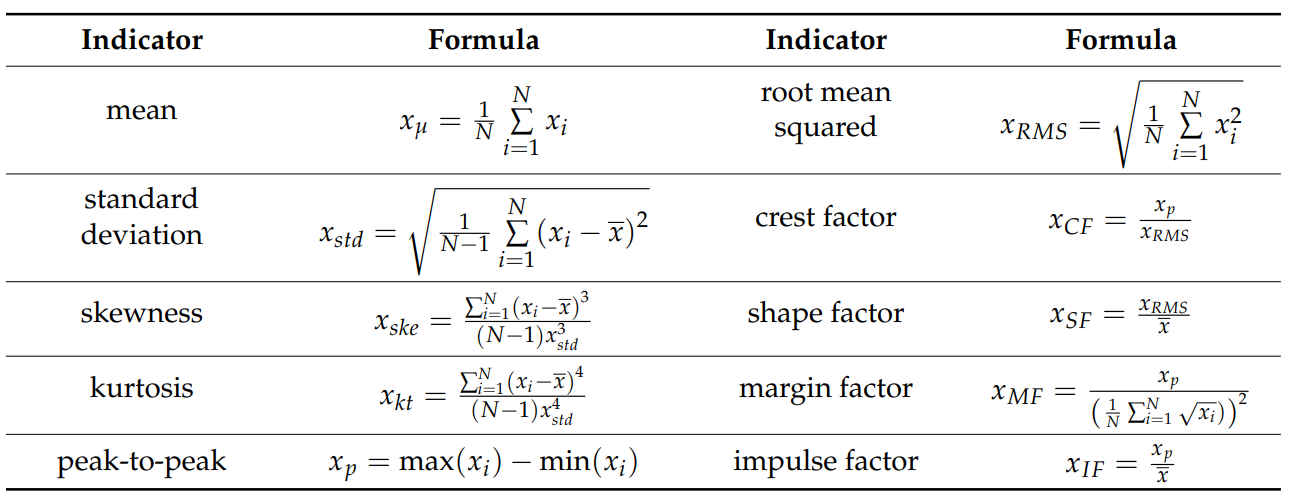

* 통계적 지표(SI)를 추출하는 함수 정의
* 0.5초씩 구간을 나누는 함수 정의
* 두 가지 함수를 실행시켜, 네 가지 class의 데이터를 0.5초로 분할한 후, SI 지표를 추출함

In [ ]:
# 통계적 지표(SI) 함수 정의
def get_mean(x):
    avg = np.mean(x)
    return(avg)

def get_std(x):
    std = np.std(x)
    return(std)

def get_skewness(x):
    skewness = sum((x - np.mean(x))**3) / ((len(x)-1)*(np.std(x)**3))
    return(skewness)

def get_kurtosis(x):
    kurtosis = sum((x - np.mean(x))**4) / ((len(x)-1)*(np.std(x)**4))
    return (kurtosis)

def get_p2p(x):
    p2p = (np.max(x) - np.min(x))
    return(p2p)

def get_rms(x):
    rms = np.sqrt(sum(x**2) / len(x))
    return(rms)

def get_crestFactor(x):
    crestFactor = get_p2p(x) / get_rms(x)
    return(crestFactor)

def get_shapeFactor(x):
    shapeFactor = get_rms(x) / get_mean(x)
    return(shapeFactor)
    
def get_marginFactor(x):
    marginFactor = np.max(x) / (np.mean((np.sqrt(abs(x))))**2)
    return(marginFactor)

def get_impulseFactor(x):
    impulseFactor = np.max(x) / np.mean(abs(x))
    return(impulseFactor)

def make_df(x, sensor_num):
    mean_value = np.apply_along_axis(get_mean, 1, x)
    std_value = np.apply_along_axis(get_std, 1, x)
    skewness_value = np.apply_along_axis(get_skewness, 1, x)
    kurtosis_value = np.apply_along_axis(get_kurtosis, 1, x)
    p2p_value = np.apply_along_axis(get_p2p, 1, x)
    rms_value = np.apply_along_axis(get_rms, 1, x)
    crestFactor_value = np.apply_along_axis(get_crestFactor, 1, x)
    shapeFactor_value = np.apply_along_axis(get_shapeFactor, 1, x)
    marginFactor_value = np.apply_along_axis(get_marginFactor, 1, x)
    impulseFactor_value = np.apply_along_axis(get_impulseFactor, 1, x)
    
    df = pd.DataFrame({'mean_'+sensor_num:mean_value, 'std_'+sensor_num:std_value, 'skewness_'+sensor_num:skewness_value, 
                       'kurtosis_'+sensor_num:kurtosis_value, 'p2p_'+sensor_num:p2p_value, 'rms_'+sensor_num:rms_value,
                       'crest_'+sensor_num:crestFactor_value, 'shape_'+sensor_num:shapeFactor_value, 
                       'margin_'+sensor_num:marginFactor_value, 'impulse_'+sensor_num:impulseFactor_value})
    
    return(df)

# 0.5초 구간별로 분할하여 SI를 측정하는 함수 정의
def generate_data(data):
  data = pd.DataFrame(data)
  df = pd.DataFrame()
  i = 0
  window_len = 500
  while data.shape[0] >= window_len:
    input = data.iloc[window_len*i:window_len*(i+1),:]
    input_arr = np.array(input).reshape((1,-1))
    df = pd.concat([df, pd.DataFrame(input_arr)], axis=0)
    # print(df)
    data = data.iloc[window_len*(i+1):,:]
    # i += 1

  df = df.reset_index(drop=True)
  return df.drop(index=df.index[-1])


def extract_SI(data):
  s1_tmp = generate_data(data[:,0])
  s2_tmp = generate_data(data[:,1])
  s3_tmp = generate_data(data[:,2])
  s4_tmp = generate_data(data[:,3])

  s1_ext = make_df(s1_tmp, 's1')
  s2_ext = make_df(s2_tmp, 's2')
  s3_ext = make_df(s3_tmp, 's3')
  s4_ext = make_df(s4_tmp, 's4')

  df = pd.concat([s1_ext, s2_ext, s3_ext, s4_ext], axis=1)
  return df


# 0.5초 분할 및 SI 측정하는 코드 실행
normal_train_ext = extract_SI(normal_train)
type1_train_ext = extract_SI(type1_train)
type2_train_ext = extract_SI(type2_train)
type3_train_ext = extract_SI(type3_train)

normal_test_ext = extract_SI(normal_test)
type1_test_ext = extract_SI(type1_test)
type2_test_ext = extract_SI(type2_test)
type3_test_ext = extract_SI(type3_test)

* Normal, Type1, Type2, Type3에 대하여 0, 1, 2, 3으로 라벨링 부여

In [ ]:
# Normal, Type1, Type2, Type3에 대하여 0, 1, 2, 3으로 라벨링 부여
normal_train_ext_labeled = np.append(normal_train_ext, np.repeat(0, normal_train_ext.shape[0]).reshape(normal_train_ext.shape[0], 1), axis=1)
type1_train_ext_labeled = np.append(type1_train_ext, np.repeat(1, type1_train_ext.shape[0]).reshape(type1_train_ext.shape[0], 1), axis=1)
type2_train_ext_labeled = np.append(type2_train_ext, np.repeat(2, type2_train_ext.shape[0]).reshape(type2_train_ext.shape[0], 1), axis=1)
type3_train_ext_labeled = np.append(type3_train_ext, np.repeat(3, type3_train_ext.shape[0]).reshape(type3_train_ext.shape[0], 1), axis=1)

normal_test_ext_labeled = np.append(normal_test_ext, np.repeat(0, normal_test_ext.shape[0]).reshape(normal_test_ext.shape[0], 1), axis=1)
type1_test_ext_labeled = np.append(type1_test_ext, np.repeat(1, type1_test_ext.shape[0]).reshape(type1_test_ext.shape[0], 1), axis=1)
type2_test_ext_labeled = np.append(type2_test_ext, np.repeat(2, type2_test_ext.shape[0]).reshape(type2_test_ext.shape[0], 1), axis=1)
type3_test_ext_labeled = np.append(type3_test_ext, np.repeat(3, type3_test_ext.shape[0]).reshape(type3_test_ext.shape[0], 1), axis=1)


print(normal_train_ext_labeled.shape)
print(type1_train_ext_labeled.shape)
print(type2_train_ext_labeled.shape)
print(type3_train_ext_labeled.shape)

* 골고루 학습하게 하기 위하여, 생성 데이터들의 Shuffling 수행

In [ ]:
combined_trn = np.concatenate((normal_train_ext_labeled, type1_train_ext_labeled, type2_train_ext_labeled, type3_train_ext_labeled))
combined_test = np.concatenate((normal_test_ext_labeled, type1_test_ext_labeled, type2_test_ext_labeled, type3_test_ext_labeled))

np.random.shuffle(combined_trn)
np.random.shuffle(combined_test)

## 3. 모델 구축



###3-1. 서포트벡터머신 (SVM)
...

### 3-2. 랜덤 포레스트 (Random Forest)
...

## 4. 모델 학습

### 4-1. 서포트벡터머신 (SVM) 모델 학습


In [ ]:
from sklearn import svm
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV

# SVM
SVM_model = svm.SVC()

param_dist = {"C" : [10, 50, 100], "kernel": ['linear', 'rbf', 'poly']}

tuned_svm = GridSearchCV(SVM_model, param_grid=param_dist, verbose=2, refit=True)
tuned_svm.fit(combined_trn[:,:-1], combined_trn[:,-1])

# 최적 파라미터 값
print(tuned_svm.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ................................C=10, kernel=linear; total time=   0.0s
[CV] END ................................C=10, kernel=linear; total time=   0.0s
[CV] END ................................C=10, kernel=linear; total time=   0.0s
[CV] END ................................C=10, kernel=linear; total time=   0.0s
[CV] END ................................C=10, kernel=linear; total time=   0.0s
[CV] END ...................................C=10, kernel=rbf; total time=   0.0s
[CV] END ...................................C=10, kernel=rbf; total time=   0.0s
[CV] END ...................................C=10, kernel=rbf; total time=   0.0s
[CV] END ...................................C=10, kernel=rbf; total time=   0.0s
[CV] END ...................................C=10, kernel=rbf; total time=   0.0s
[CV] END ..................................C=10, kernel=poly; total time=   0.0s
[CV] END ..................................C=10, 

### 4-2. 랜덤 포레스트 (Random Forest) 모델 학습


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
RF_model = RandomForestClassifier()

param_dist = {"n_estimators": [100, 200, 400, 800],
              "max_depth": [10, 20, 40]}

tuned_rf = GridSearchCV(RF_model, param_grid=param_dist, verbose=2, refit=True)
tuned_rf.fit(combined_trn[:,:-1], combined_trn[:,-1])

# 최적 파라미터 값
print(tuned_rf.best_params_)

모델을 선택하여 학습하기 위한 함수를 정의함

In [ ]:
def train_model(model, criterion, optimizer, num_epoch, train_dataloader, PATH):
    loss_values = []
    loss_values_v = []
    check = 0; accuracy_past = 0
    for epoch in range(1, num_epochs + 1):
        #---------------------- 모델 학습 ---------------------#
        model.train()
        batch_number = 0
        running_loss = 0.0
        for batch_idx, samples in enumerate(train_dataloader):
            x_train, y_train = samples
            
            # 변수 초기화
            optimizer.zero_grad() 
            y_hat = model.forward(x_train)
            loss = criterion(y_hat,y_train.long())
            # 모델의 파라미터와 관련된 loss의 그래디언트 계산
            loss.backward()
            # 신경망 가중치(parameter) 업데이트
            optimizer.step()
            
            running_loss += loss.item()
            batch_number += 1
        loss_values.append(running_loss / batch_number)
        #------------------------------------------------------#
        
        #---------------------- 모델 검증 ---------------------#
        model.eval()
        accuracy = 0.0
        total = 0.0
        for batch_idx, data in enumerate(valid_dataloader):
            x_valid, y_valid = data
            
            v_hat = model.forward(x_valid)
            v_loss = criterion(v_hat,y_valid.long())

            _, predicted = torch.max(v_hat.data, 1)
            total += y_valid.size(0)
            accuracy += (predicted == y_valid).sum().item()
        loss_values_v.append(loss.item())
        accuracy = (accuracy / total)
        #------------------------------------------------------#
        # Check for early stopping
        
        if epoch % 2 == 0:
            print('[Epoch {}/{}] [Train_Loss: {:.6f} , Valid_Loss: {:.6f} , Accuracy: {:.6f}]'.format(epoch, num_epochs, loss.item(), v_loss.item(), accuracy))
            
        if accuracy_past > accuracy:
            check += 1
        else:
            check = 0
            accuracy_past = accuracy
        
        if check > 50:
            print('This is time to do early stopping')
                
    torch.save(model, PATH + 'model.pt')
    return loss_values, loss_values_v

## 5. 모델 평가

#### ML모델 평가

#### 5-1. 서포트벡터머신 (SVM) 모델 성능 평가

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

y_pred = tuned_svm.predict(combined_test[:,:-1])

accuracy = accuracy_score(combined_test[:,-1], y_pred)
f1 = f1_score(combined_test[:,-1], y_pred, average='weighted')
print('Accuracy: ', "%.2f" % (accuracy*100))
print('F1: ', "%.2f" % (f1*100))

# Confusion Matrix 생성
Confusion_Matrix = confusion_matrix(combined_test[:,-1], y_pred)

cm_df = pd.DataFrame(Confusion_Matrix,
                     index = ['normal','type1','type2','type3'], 
                     columns = ['normal','type1','type2','type3'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal')
plt.xlabel('Predicted')
plt.show()

#### 5-2. 랜덤 포레스트 (Random Forest) 모델 성능 평가

In [ ]:
y_pred = tuned_rf.predict(combined_test[:,:-1])

accuracy = accuracy_score(combined_test[:,-1], y_pred)
f1 = f1_score(combined_test[:,-1], y_pred, average='weighted')
print('Accuracy: ', "%.2f" % (accuracy*100))
print('F1: ', "%.2f" % (f1*100))

# Confusion Matrix 생성
Confusion_Matrix = confusion_matrix(combined_test[:,-1], y_pred)

cm_df = pd.DataFrame(Confusion_Matrix,
                     index = ['normal','type1','type2','type3'], 
                     columns = ['normal','type1','type2','type3'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal')
plt.xlabel('Predicted')
plt.show()